# 2階層でのPredictie Codingの確認

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from dataset import Dataset

I_scale = 10.0
dataset = Dataset(scale=I_scale)

In [3]:
#k1 = 0.5
#k2 = 1.0

k1 = 0.0005 # rの学習率
k2 = 0.005 # Uの学習率

iteration = 30

sigma_sq    = 1.0  # Iの生成観測分布の分散
sigma_sq_td = 10.0 # rの生成観測分布の分散
alpha1      = 1.0  # rの事前分布の精度パラメータ  (分散=1.0, 標準偏差1.0)
alpha2      = 0.05 # rhの事前分布の精度パラメータ (分散=20.0, 標準偏差4.5)
lambd       = 0.02 # Uの事前分布の精度パラメータ　(分散=50.0, 標準偏差7.1)

U_scale     = 7.0

Us  = (np.random.rand(3,256,32)-0.5) * U_scale
Uh  = (np.random.rand(96,128)  -0.5) * U_scale
rs  = np.zeros([96],  dtype=np.float32)
rh  = np.zeros([128], dtype=np.float32)

patch_size = len(dataset.patches) # 2375

for k in range(patch_size):
    rs = np.zeros([96], dtype=np.float32)
    rh = np.zeros([128], dtype=np.float32)    
    
    #rs = np.random.randn(96).astype(np.float32) * 1.0
    #rh = np.random.randn(128).astype(np.float32) * 4.5
    
    error_tds = np.zeros([96], dtype=np.float32)
    
    for i in range(iteration):
        r_tds = Uh.dot(rh)
        
        for j in range(3):
            I = dataset.get_image(k, j)
            r    = rs[32*j:32*(j+1)]
            r_td = r_tds[32*j:32*(j+1)]
            U = Us[j]
            Ur = U.dot(r)
            error    = I - Ur
            error_td = r_td - r
            dr = (k1 / sigma_sq) * U.T.dot(error) + (k1/sigma_sq_td) * error_td - k1 * alpha1 * r
            dU = (k2 / sigma_sq) * np.outer(error, r) - k2 * lambd * U
            rs[32*j:32*(j+1)] += dr
            Us[j] += dU            
            error_tds[32*j:32*(j+1)] = error_td
            
        # こちらはerror_tdsは反転する必要ある
        drh = (k1 / sigma_sq_td) * Uh.T.dot(-error_tds)     - k1 * alpha2 * rh
        dUh = (k2 / sigma_sq_td) * np.outer(-error_tds, rh) - k2 * lambd * Uh        

        rh += drh
        Uh += dUh

    if k % 100 == 0:
        print("us mean={:.2f} std={:.2f}".format(np.mean(Us[0]), np.std(Us[0])))                                    
        print("rs mean={:.2f} std={:.2f}".format(np.mean(rs), np.std(rs)))
        print("r_tds mean={:.2f} std={:.2f}".format(np.mean(r_tds), np.std(r_tds)))
        print("U  mean={:.2f} std={:.2f}".format(np.mean(Us), np.std(Us)))
        print("Uh mean={:.2f} std={:.2f}".format(np.mean(Uh), np.std(Uh)))
    
    if k % 40 == 0:
        k2 = k2 / 1.015

us mean=-0.01 std=2.05
rs mean=-0.16 std=1.09
r_tds mean=-0.06 std=0.50
U  mean=0.01 std=2.04
Uh mean=-0.02 std=2.01
us mean=-0.05 std=1.60
rs mean=-0.40 std=2.43
r_tds mean=-0.19 std=1.06
U  mean=-0.01 std=1.60
Uh mean=-0.02 std=1.51
us mean=-0.03 std=1.40
rs mean=-0.05 std=1.19
r_tds mean=-0.01 std=0.32
U  mean=0.00 std=1.39
Uh mean=-0.01 std=1.14
us mean=-0.04 std=1.18
rs mean=-0.04 std=2.53
r_tds mean=-0.02 std=0.62
U  mean=-0.01 std=1.18
Uh mean=-0.01 std=0.87
us mean=-0.02 std=1.18
rs mean=0.18 std=1.82
r_tds mean=0.02 std=0.24
U  mean=-0.00 std=1.17
Uh mean=-0.01 std=0.67
us mean=-0.03 std=1.06
rs mean=0.20 std=2.34
r_tds mean=0.06 std=0.37
U  mean=-0.01 std=1.06
Uh mean=-0.01 std=0.53
us mean=-0.01 std=1.09
rs mean=0.31 std=2.13
r_tds mean=0.03 std=0.20
U  mean=-0.00 std=1.09
Uh mean=-0.01 std=0.42
us mean=-0.02 std=1.01
rs mean=0.49 std=2.38
r_tds mean=0.05 std=0.23
U  mean=-0.01 std=1.01
Uh mean=-0.00 std=0.33
us mean=-0.01 std=1.09
rs mean=0.03 std=1.32
r_tds mean=0.00 std=0

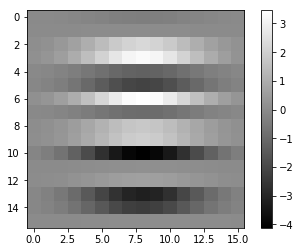

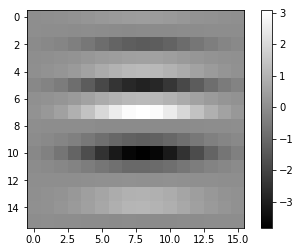

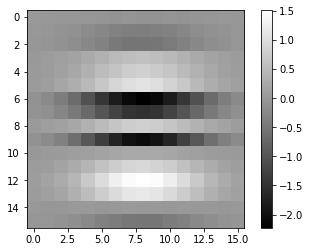

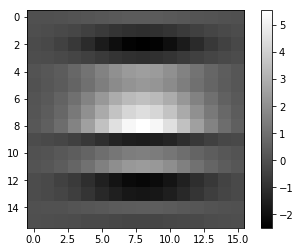

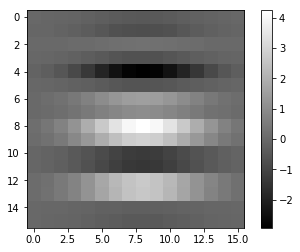

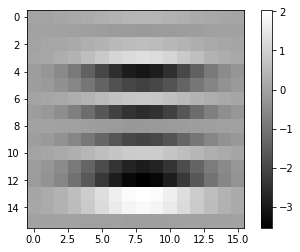

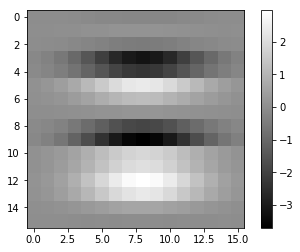

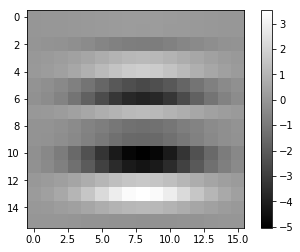

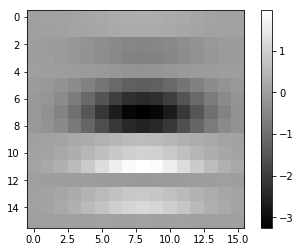

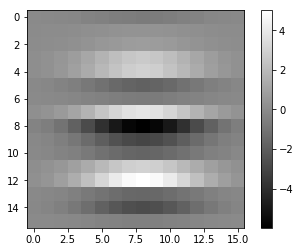

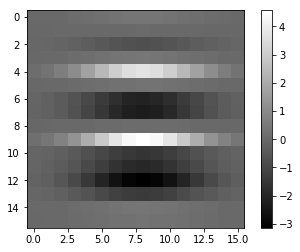

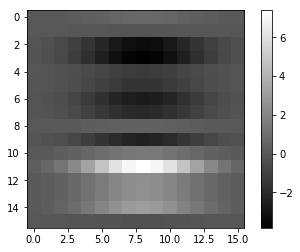

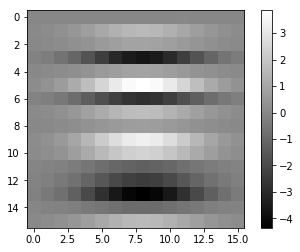

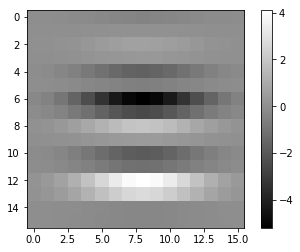

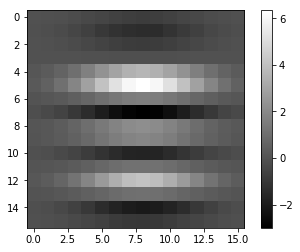

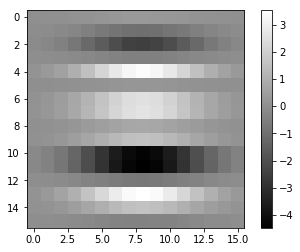

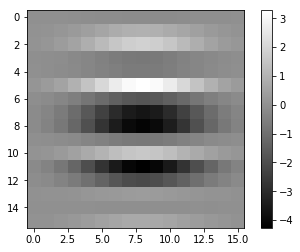

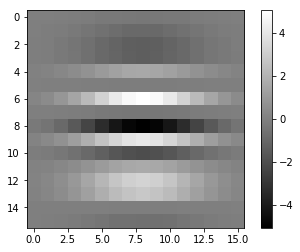

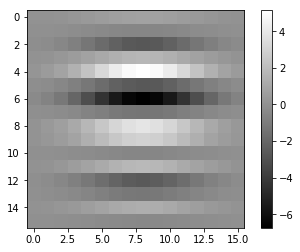

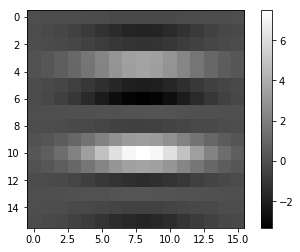

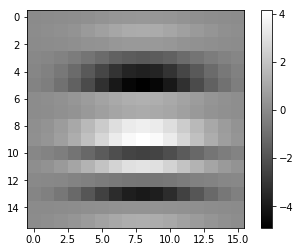

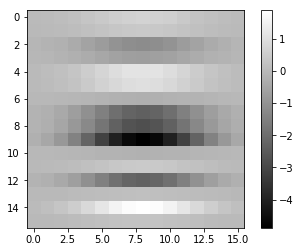

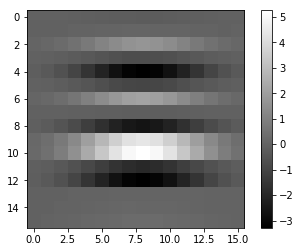

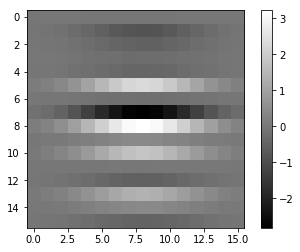

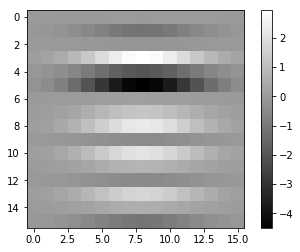

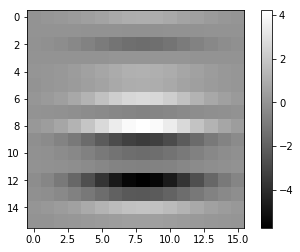

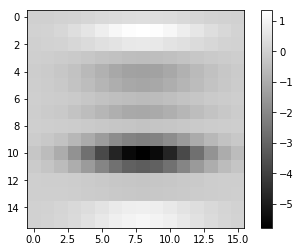

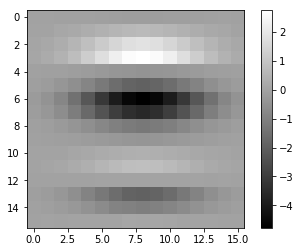

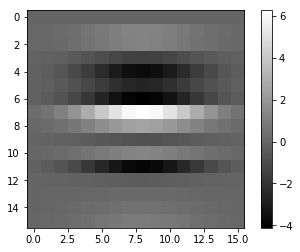

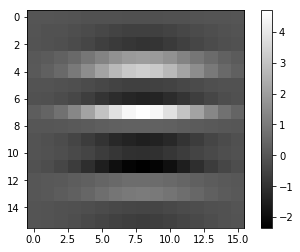

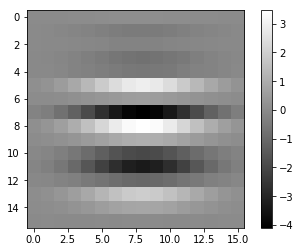

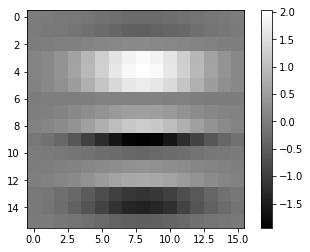

In [4]:
for i in range(32):
    u = Us[1][:,i].reshape(16,16)
    plt.figure()
    plt.imshow(u, cmap='gray')
    plt.colorbar()
    plt.show()

In [58]:
print(Uh.shape) # (96, 128)
print(np.std(Uh))
print(np.std(Us))
print(np.std(rs))

(96, 128)
0.018304107334956056
0.880256845823838
1.167215


In [61]:
np.mean(rs - r_tds)

0.0003488396740341583

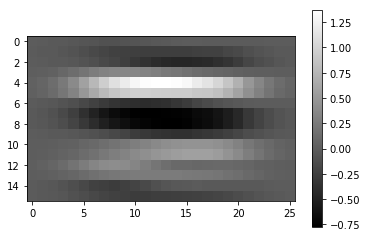

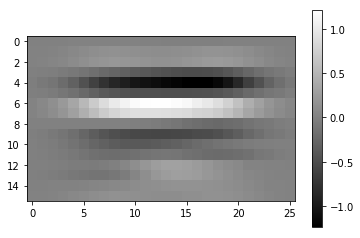

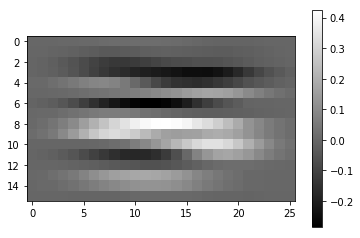

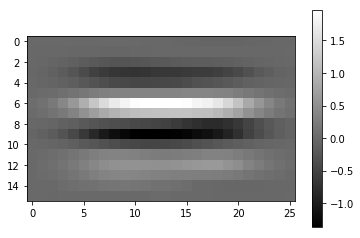

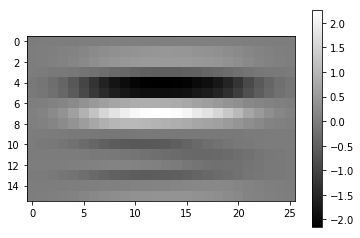

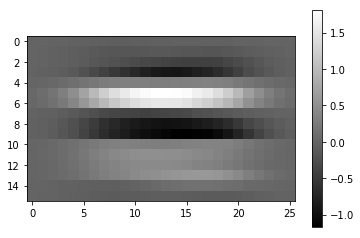

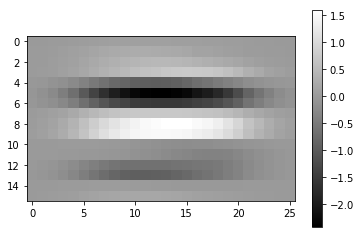

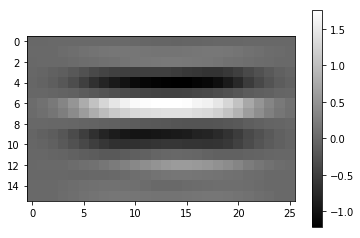

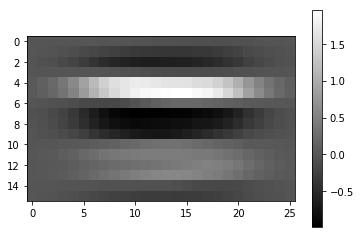

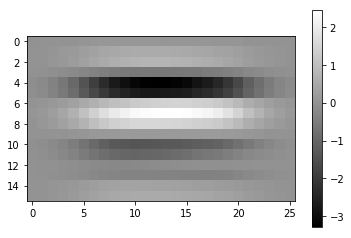

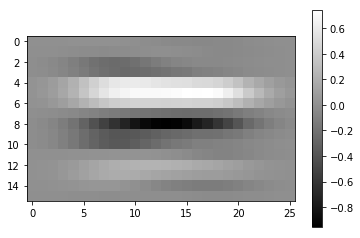

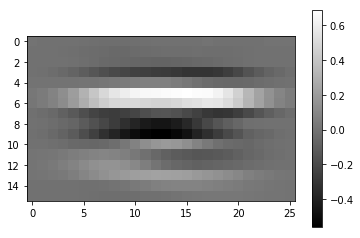

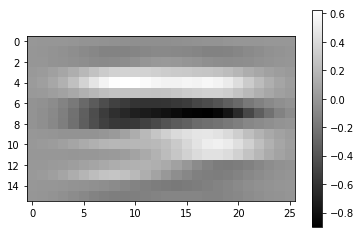

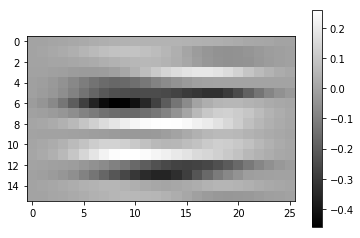

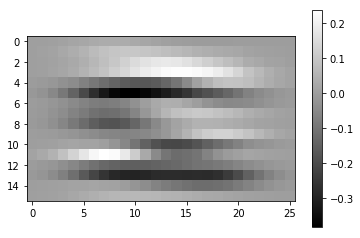

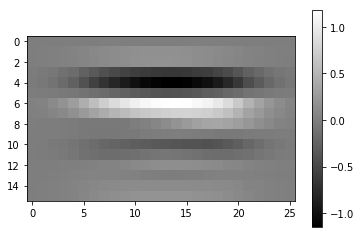

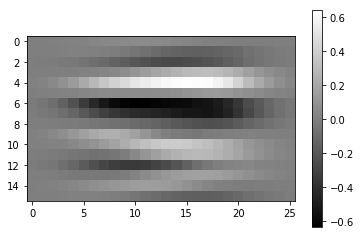

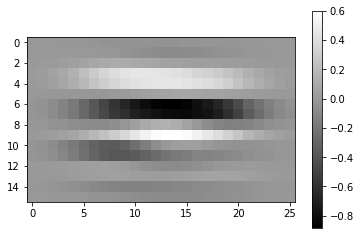

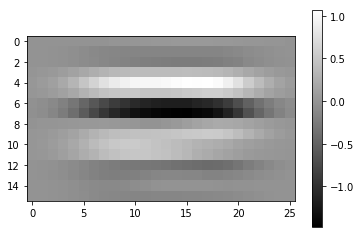

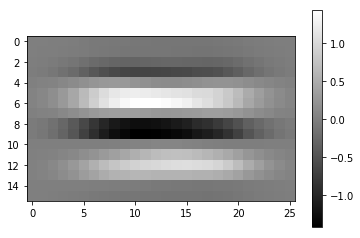

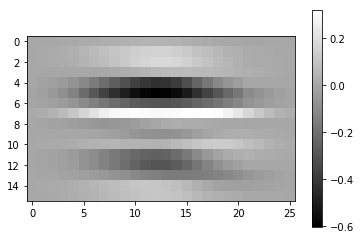

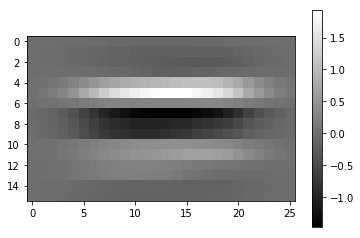

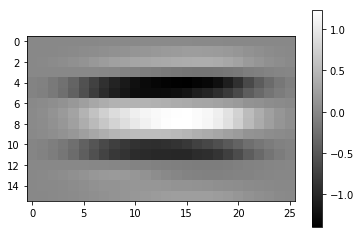

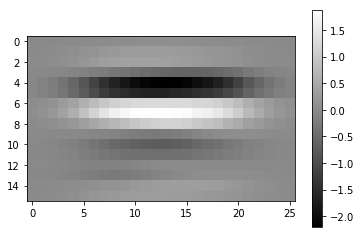

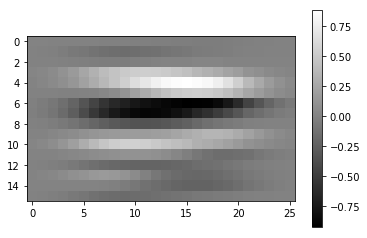

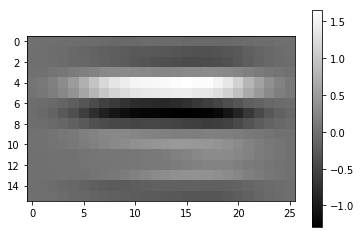

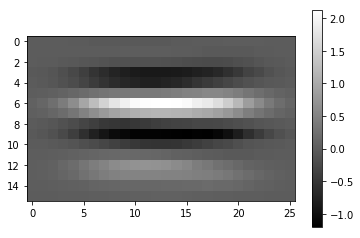

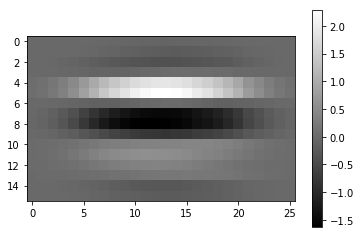

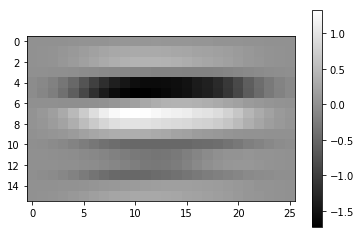

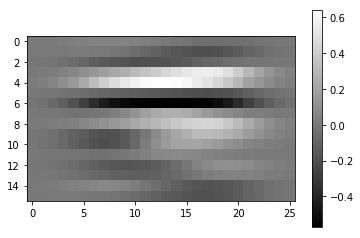

In [5]:
def get_level2_rf(index):
    Uh0 = Uh[:,index][0:32]
    Uh1 = Uh[:,index][32:64]
    Uh2 = Uh[:,index][64:96]

    UU0 = Us[0].dot(Uh0).reshape((16,16))
    UU1 = Us[1].dot(Uh1).reshape((16,16))
    UU2 = Us[2].dot(Uh2).reshape((16,16))

    RF = np.zeros((16,26), dtype=np.float32)
    RF[:, 5*0:5*0+16] += UU0
    RF[:, 5*1:5*1+16] += UU1
    RF[:, 5*2:5*2+16] += UU2    
    return RF

for i in range(30):
    rf = get_level2_rf(i)    
    plt.figure()
    plt.imshow(rf, cmap='gray')
    plt.colorbar()
    plt.show()

In [48]:
import imageio
import cv2
import os

In [49]:
if not os.path.exists("result"):
    os.mkdir("result")

for i in range(32):
    u1 = Us[1][:,i].reshape(16,16)
    u1 = cv2.resize(u1, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)
    imageio.imwrite("result/u1_{:0>2}.png".format(i), u1)
    
for i in range(128):
    u2 = get_level2_rf(i)
    u2 = cv2.resize(u2, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)
    imageio.imwrite("result/u2_{:0>3}.png".format(i), u2)